## Campaign altitude




In [365]:
# imports from packages
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as creature
import glob
import os
import sys # to test parts of code with sys.exit()
import math
import seaborn as sns

import functions
import numb_conc # functions relating to number concenctration calculations
import plots


In [366]:
# --- Global formatting/settings/variables

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# --- Thresholds for in-cloud values
# ----- Water content threshold
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

# ----- Number concentration threshold
# Following table 2 from Evans et al 2025:
# Ice concentration threshold to define ice = 0.1 L-1 (or m-3) (NT100 is given in m-3)
# Cdp drop concentration to define liquid = 2 cm-3 (numb conc corrected is given in cm-3)

n_ice_th = 0.1
n_drp_th = 2

# --- Select preselect options

# ----- In cloud threshold method
# Options:
# - 'LWC_th' based on only LWC
# - 'TWC_th' based on only TWC
# - 'LWC_IWC_th' based on LWC and IWC
# - 'N_th' based on number concentration from both CDP and CIP
th_method = 'LWC_IWC_th'

# --- Preselection options

#preselect = False # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)
preselect = True # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)

preopt = ''
rm_cirrus = True # remove cirrus by only looking at
rm_c_T = -35
marine = True # only use marine values (values larger than given lat)
m_lat = 70
rm_precip = False # remove precip based on selection
rm_roll = True # only use values where Rol is less than 5
roll_th = 5


# set saving paths based on preselection options
if preselect == False:
    pre_text=''
    if rm_cirrus == True:
        preopt = preopt + f'rmCir{rm_c_T}_'
        pre_text = pre_text + f'Cirrus removed (>{rm_c_T}), '
    if marine == True:
        preopt = preopt + f'mar{m_lat}_'
        pre_text = pre_text + f'only marine (lat>70), '
    if rm_precip == True:
        preopt = preopt + f'rmPre{m_lat}_'
        pre_text = pre_text + f'Precip removed, '
    if rm_roll == True:
        preopt = preopt + f'rmRoll{roll_th}_'
        pre_text = pre_text + f'Roll removed, '
        
    save_path = '/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/Pre_selection/' #+preopt 

else:
    #save_path = 'save_images/Alldata/'
    #save_path = 'save_images/EGU/'
    save_path = '/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/'
    pre_text = 'no preselect'


print(pre_text)
extr_txt = ''
#extr_txt = '(allin_off)'

no preselect


In [ ]:
# --- Data import
# Import the processed data:
main_path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/ISLAS_processed' # regular path
file_struct = '/microphy_5s_*.nc' # structure of cip text-file names


# get all the .nc files in the main path
files = glob.glob(os.path.join(main_path, file_struct))
files = glob.glob(main_path+file_struct)

# Exclude the file containing 'IS22-09' (flew over land)
files_to_exclude = [f for f in files if 'IS22-09' in os.path.basename(f)]
files_to_include = [f for f in files if f not in files_to_exclude]


ds = xr.open_mfdataset(files_to_include, combine='by_coords', combine_attrs='drop_conflicts') # drop the IS22-09 flight

# sea ice information from satellite
min_date = '20220322'
#min_date = '20220324'
#min_date = '20220326'
#min_date = '20220329'
#min_date = '20220330'
#min_date = '20220331'
max_date = '20220403'
sic_max_ds = xr.open_dataset('/home/ninalar/Documents/MC2/procIslasMicrophy/sea_ice_satellite/asi-n6250-' + max_date + '-5.4_regridded.nc')
sic_max_ds.close()
sic_min_ds = xr.open_dataset('/home/ninalar/Documents/MC2/procIslasMicrophy/sea_ice_satellite/asi-n6250-' + min_date + '-5.4_regridded.nc')
sic_min_ds.close()

# rename data variable and update attributes
sic_max_ds['sic'] = sic_max_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
sic_max_ds = sic_max_ds.drop_vars(['__xarray_dataarray_variable__'])
sic_min_ds['sic'] = sic_min_ds['__xarray_dataarray_variable__'].assign_attrs(units="Percent", description="Sea Ice Concentration")
sic_min_ds = sic_min_ds.drop_vars(['__xarray_dataarray_variable__'])

# add some attributes
sic_max_ds.attrs['date'] = max_date
sic_max_ds.attrs['file'] = f'asi-n6250-{min_date}-5.4_regridded.nc'
sic_min_ds.attrs['date'] = min_date
sic_min_ds.attrs['file'] = f'asi-n6250-{min_date}-5.4_regridded.nc'


In [ ]:
#---- Select incloud, relevant values

# commenting out all other masks for the EGU version

# Masks for different types of selections 
#lwc_mask = (ds['LWC corr']>=lwc_th).compute() # mask the values based on lwc according to threshold
#twc_mask = (ds['TWC']>=lwc_th).compute() # mask the values based on twc according to threshold
lwc_iwc_mask = ((ds['LWC corr']>= lwc_th)|(ds['IWC100']>= lwc_th)).compute() # mask the values based on lwc or iwc according to threshold
#nt_mask = ((ds['Number Conc corr']>= n_drp_th)|(ds['NT100']>= n_ice_th)).compute()


# --- First selection: all data or only lower clouds/relevant data, only marine data
if preselect == True:
    # select only marine values (lat higher than 70)
    if marine == True:
        marinelat_mask = (ds['lat']>=m_lat).compute()
        ds_relevant = ds.where(marinelat_mask, drop = True)

    if rm_cirrus == True:
        # select only values where temperature is higher than selected temperature (avoid cirrus)
        cirrusT_mask = (ds['T']>=rm_c_T).compute()
        ds_relevant = ds_relevant.where(cirrusT_mask, drop = True)

    if rm_roll == True:
        # select only values where roll is less than selected threshold
        roll_mask = (ds['ROLL']<=roll_th).compute()
        ds_relevant = ds_relevant.where(roll_mask, drop=True)

    
else:
    ds_relevant = ds

# ---- Second selection: what should be considered in-cloud?
# th_method is used to selecting the selection criteria and is added to saved plots for organizing
if th_method == 'LWC_th':
    # only lwc have to be larger than threshold, use lwc mask
    incloud_mask = lwc_mask
    th = f'{lwc_th} m^-3, (LWC)'
elif th_method == 'TWC_th':
    # twc have to be larger than threshold value, use twc mask
    incloud_mask = twc_mask
    th = f'{lwc_th} m^-3, (TWC)'
elif th_method == 'LWC_IWC_th':
    # either lwc or iwc needs to be larger than the threshold, use lwc_iwc_mask
    incloud_mask = lwc_iwc_mask
    th = f'{lwc_th} m^-3, (LWC or IWC)'
elif th_method == 'N_th':
    incloud_mask = nt_mask
    th = f'Nt_cdp>{n_drp_th} cm^-3, Nt_cip100>{n_ice_th} L^-1'
else:
    print('WARNING: in-cloud threshold method not defined!')

# create the selected dataset based on selected mask
ds_incloud = ds_relevant.where(incloud_mask, drop = True)

# --- Third selection: selection and removal of precip values

if rm_precip == True:
    # use the remove precip in all the plots
    ds_incloud = ds_incloud.where(~precip_mask, drop=True)
    
# store precip/noprecip separately: (Dont care about precip for EGU
#ds_incloud_noprecip = ds_incloud.where(~precip_mask, drop=True)# Remove precip from incloud
#ds_precip= ds_incloud.where(precip_mask, drop = True) # save only precip

# Printing sizes of datasets for overview:
print(f'Full dataset size: {len(ds.time)}')
print(f'Relevant(over sea, warmer than -35) dataset size: {len(ds_relevant.time)}')
print(f'In-cloud threshold: {lwc_th} g/m3')
#print(f'Incloud dataset (LWC_th) size: {len(ds_relevant.where(lwc_mask, drop=True).time)}')
#print(f'Incloud dataset (TWC_th) size: {len(ds_relevant.where(twc_mask, drop=True).time)}')
print(f'Incloud dataset (LWC_IWC_th) size: {len(ds_relevant.where(lwc_iwc_mask, drop=True).time)}')
print(f'Used dataset: {th_method}, size:{len(ds_incloud.time)}')



Full dataset size: 22392
Relevant(over sea, warmer than -35) dataset size: 11572
In-cloud threshold: 0.01 g/m3
Incloud dataset (LWC_IWC_th) size: 5314
Used dataset: LWC_IWC_th, size:5314


In [369]:
# in-cloud "sample distances" based on 5 sek values over the max an min TAS
print(f'Min TAS: {ds_incloud.TAS.values.min()} m/s')
print(f'Min sample distance (5 s sample): {ds_incloud.TAS.values.min()*5} m')
print(f'Max TAS: {ds_incloud.TAS.values.max()} m/s')
print(f'Max sample distance (5 s sample): {ds_incloud.TAS.values.max()*5} m')
print(f'max incloud altitude: {ds_incloud.alt.values.max()} m')
print(f'min incloud altitude: {ds_incloud.alt.values.min()} m')

Min TAS: 59.0 m/s
Min sample distance (5 s sample): 295.0 m
Max TAS: 143.0 m/s
Max sample distance (5 s sample): 715.0 m
max incloud altitude: 4885.04052734375 m
min incloud altitude: 83.09110260009766 m


In [370]:
# --- Preparations for altitude based plots
# create categorical altitude variable based on altitude values (for in-cloud, relevant and precip data

# Define the bin edges for the altitude (based on the incloud data
altitude_bins = np.arange(0, ds_incloud['alt'].max() + 300, 300) # based on max values in data
bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
print(altitude_bins)

# need to add altitude binning information(based on in-cloud values) to all datasets 
def add_alt_bins(ds, altitude_bins):
    # digitize altitude data into bins
    alt_bin_indices = np.digitize(ds['alt'], bins = altitude_bins)

    ds = ds.assign_coords(altitude_bin=('time', alt_bin_indices)) # on 'time' dimension

    # Label bins by midpoints
    bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
    ds['altitude_bin'].data = bin_labels[alt_bin_indices - 1]
    ds.coords['altitude_bin']=ds.coords['altitude_bin'].astype(int)
    return ds

# in-cloud
ds_incloud = add_alt_bins(ds_incloud, altitude_bins) # add altitude binning information

# relevant clouds (all data)
alt_mask = (ds_relevant['alt'] <= altitude_bins.max()).compute()
ds_relevant = ds_relevant.where(alt_mask, drop = True) 
ds_relevant = add_alt_bins(ds_relevant, altitude_bins) # add altitude binning information

[   0.  300.  600.  900. 1200. 1500. 1800. 2100. 2400. 2700. 3000. 3300.
 3600. 3900. 4200. 4500. 4800. 5100.]


In [371]:
# datapoints per altitude bins and statistics
print(f'#datapoints per altitudebin: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values}')
print(f'Min #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.min()}')
print(f'Max #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.max()}')
print(f'Mean #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.mean()}')

#datapoints per altitudebin: [ 219 1279  503  538 1014  536  215  122   32  425   23   26   93  281
    7    1]
Min #datapoints: 1
Max #datapoints: 1279
Mean #datapoints: 332.125


In [373]:
# --- Functions (add to file later)
def plot_flight_obs(lat_bands, ds, ds_incloud, sic_max_ds,sic_min_ds, title, obs, savefile = ''):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    #colors for flights (for consistent coloring in plots)
    c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:orange',
              'IS22-03':'tab:cyan',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:pink',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:red',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:grey',
              'IS22-10':'tab:blue',
              'IS22-11':'tab:green'}

    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get the flightids
    flights = np.unique(ds.islasid.values)

    for flight in flights:
        
        # Select out the data connected with the flight
        f1_mask = (ds['islasid']==flight).compute()
        ds_f = ds.where(f1_mask, drop = True)
        f1_mask = (ds_incloud['islasid']==flight).compute()
        ds_incloud_f = ds_incloud.where(f1_mask, drop = True)


        # get datavalues for plotting lines
        lat_values = ds_f['lat'].values
        lon_values = ds_f['lon'].values

        # get datavalues for plotting incloud values
        obs_lat_values = ds_incloud_f['lat'].values
        obs_lon_values = ds_incloud_f['lon'].values
        
        if obs == True:
            # plot all lat-lon points and where incloud obs
            ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], alpha=0.01, transform = data_projection)
            ax.scatter(obs_lon_values, obs_lat_values, marker='o',label=flight, c= c_flights[flight], transform = data_projection)
        else:
            ax.scatter(lon_values, lat_values, marker='.', c=c_flights[flight], transform = data_projection, label = flight)

    # Draw latitude bands
    for lat_band in lat_bands:
        ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
        if lat_band in [lat_min, lat_max]:
            lat_text = round(lat_band, 2)
        else:
            lat_text = lat_band
        ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='k', 
                rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Text for northern and southern marine

    ax.text(30, 75.5, "Northern \n marine region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='tab:blue', 
                rotation=30)
    ax.text(30, 71.5, "Southern \n marine \n region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='tab:red', 
                rotation=30)
    
    # add sea ice concentration
    cs = ax.contour(sic_max_ds['lon'],sic_max_ds['lat'],sic_max_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashed')
    contour_legend_max = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='25% Sea Ice \n concentration')
    cs_m = ax.contour(sic_max_ds['lon'],sic_min_ds['lat'],sic_min_ds['sic'], transform=ccrs.PlateCarree(),levels=[15.], colors='tab:grey', linestyles='dashdot')
    contour_legend_min = mlines.Line2D([], [], color='tab:grey',linestyle='-.', label='25% Sea Ice \n concentration')
    
    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='yellow', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    ax.set_title(f'{title}', fontsize = 25)

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    # append handles and labels with new title
    handles.append(title_proxy)
    labels.append('25% Sea Ice conc.')
    #append with sea ice information
    handles.append(contour_legend_max)
    max_date_obj = pd.to_datetime(sic_max_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Max: {max_date_obj.strftime('%b')} {max_date_obj.strftime('%d')}')
    handles.append(contour_legend_min)
    min_date_obj = pd.to_datetime(sic_min_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Min: {min_date_obj.strftime('%b')} {min_date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=11, title = 'ISLAS Flight')
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile, bbox_inches='tight')


def plot_lat_bands(lat_bands, ds, ds_incloud,sic_max_ds,sic_min_ds, title, savefile = ''):
    # Function to plot the observations per flight, and indicate the norhtern and southern region
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
    import matplotlib.lines as mlines
    from matplotlib.patches import Rectangle

   # coordinates of Kiruna TODO: remove?
    lat_kir = 67.8256
    lon_kir = 20.3351

    # set colors
    n_col='tab:blue'
    s_col='tab:red'
    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get datavalues for plotting
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values

    # select out northern marine in cloud values
    n_mask = (ds_incloud['region'] == 'north').compute()
    n_ds = ds_incloud.where(n_mask, drop=True)
    n_lat_values = n_ds['lat'].values
    n_lon_values = n_ds['lon'].values
    
    # select out southern marine in cloud values
    s_mask = (ds_incloud['region'] == 'south').compute()
    s_ds = ds_incloud.where(s_mask, drop=True)
    s_lat_values = s_ds['lat'].values
    s_lon_values = s_ds['lon'].values


    ax.scatter(lon_values, lat_values, marker='.',c='darkgrey', label='Flight path', transform = data_projection)
    ax.scatter(n_lon_values, n_lat_values, marker='o',c=n_col, label=f'Northern marine region \n in-cloud ({len(n_lon_values)} obs)', transform = data_projection)
    ax.scatter(s_lon_values, s_lat_values, marker='o',c=s_col, label=f'Southern marine region \n in-cloud ({len(s_lon_values)} obs)', transform = data_projection)

    # Draw latitude bands
    for lat_band in lat_bands:
        ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
        if lat_band in [lat_min, lat_max]:
            lat_text = round(lat_band, 2)
        else:
            lat_text = lat_band
        ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='k', 
                rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Text for northern and southern marine

    ax.text(30, 75.5, "Northern \n marine region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=n_col, 
                rotation=30)
    ax.text(30, 71.5, "Southern \n marine \n region", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=s_col, 
                rotation=30)

    # add sea ice concentration
    cs = ax.contour(sic_max_ds['lon'],sic_max_ds['lat'],sic_max_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashed')
    contour_legend_max = mlines.Line2D([], [], color='tab:grey',linestyle='--', label='25% Sea Ice \n concentration')
    cs_m = ax.contour(sic_max_ds['lon'],sic_min_ds['lat'],sic_min_ds['sic'], transform=ccrs.PlateCarree(),levels=[25.], colors='tab:grey', linestyles='dashdot')
    contour_legend_min = mlines.Line2D([], [], color='tab:grey',linestyle='-.', label='25% Sea Ice \n concentration')
    
    #Plot Kiruna 
    #ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection) #add dot for kiruna, do not use
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-5, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    ax.set_title(f'{title}', fontsize = 25)

    handles, labels = ax.get_legend_handles_labels() # get exisiting labels
    title_proxy = Rectangle((0,0), 0, 0, color='w') # create second "title"
    # append handles and labels with new title
    handles.append(title_proxy)
    labels.append('25% Sea Ice conc.')
    #append with sea ice information
    handles.append(contour_legend_max)
    max_date_obj = pd.to_datetime(sic_max_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Max: {max_date_obj.strftime('%b')} {max_date_obj.strftime('%d')}')
    handles.append(contour_legend_min)
    min_date_obj = pd.to_datetime(sic_min_ds.attrs['date'], format='%Y%m%d')
    labels.append(f'Min: {min_date_obj.strftime('%b')} {min_date_obj.strftime('%d')}')

    plt.legend(handles=handles, labels=labels, loc='lower left', fontsize=12)
    plt.tight_layout()
    if savefile !='':
        plt.savefig(savefile, bbox_inches='tight')

def create_counts(ds, lat_bins):
    # Function to create counts array tu use when making heatmaps. Keeps control of normalizations etc.
    # Input: 
    # --- ds: dataset, that at least have 'base_time' and an altitude as parameters
    # --- lat_bins: title to add to plot
    # output:
    # --- count_df: df ouf number of observations per latitudebin and altitude bin for the given dataset

    grouped_data = ds['base_time'].groupby_bins('lat', bins=lat_bins) #group on lat binsbins
    
    count_data = grouped_data.map(lambda group: group.groupby('altitude_bin').count())
    
    # reorganize data before plotting heatmap
    # - turn into dataframe - unstack to get correct array structure  
    count_df = count_data.to_dataframe().unstack()
    
    # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
    count_df = count_df.T.reset_index(level=0, drop = True)
    # -  make sure all possible altitude bins are represented, fill with 0 - reverse order of altitudes
    count_df = count_df.reindex(bin_labels, fill_value=0).iloc[::-1] #
    count_df = count_df.fillna(0) # set nan to 0 (for easier plot management)
    count_df = count_df.astype(int) # set the count to int
    count_df = count_df.iloc[:, ::-1] # reverse the columns to get the northern most values to the left
    #fix labels 
    new_labels = [f"[{label.right}, {label.left})" for label in count_df.columns]
    count_df.columns = new_labels
    
    return count_df

def calculate_slf(ds, iwc_param, lwc_param):
    """Calculate Supercooled liquid fraction(SLF) from given IWC and LWC parameters

    Parameters
    ----------
    ds
        xarray dataset that includes at least one IWC parameter and at least one LWC parameter
    iwc_param
        Name of IWC parameter to use for calculation of SLF
    lwc_param
        Name of LWC parameter to use for calculation of SLF

    Returns
    -------
    ds
        Updated xarray dataset that includes TWC and SLF calculated from the given IWC and LWC parameters
    """
    ds['TWC'] = ds[iwc_param]+ds[lwc_param] # first calculate TWC
    # update TWC attributes
    ds['TWC'].attrs['longname']='Total Water Content'
    ds['TWC'].attrs['unit']='g/m^3'
    ds['TWC'].attrs['description']='Sum of Liquid and Ice Water Content'
    ds['TWC'].attrs['calculated from']=[iwc_param,lwc_param]

    ds['SLF'] = (ds[lwc_param]/ds['TWC'])*100 # calculate SLF in percent
    ds['SLF'].attrs['longname']='Supercooled Liquid Fraction'
    ds['SLF'].attrs['unit']='Percent'
    ds['SLF'].attrs['description']='Liquid Water Content divided by Total Water Content'
    ds['SLF'].attrs['calculated from']=[lwc_param, 'TWC']

    
    return ds

In [ ]:
# Calculate SLF (Korolev version)
ds_incloud = calculate_slf(ds_incloud,'IWC100','LWC corr')
ds_incloud

<xarray.Dataset> Size: 21MB
Dimensions:                 (time: 5314, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 43kB 2022-03-22T11:39:01 .....
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 21kB 70.2 70.22 70.23 ... 74.96 74.95
    lon                     (time) float32 21kB 20.38 20.37 ... 20.88 20.88
    alt                     (time) float32 21kB 3.863e+03 3.866e+03 ... 840.7
    islasid                 (time) <U7 149kB 'IS22-02' 'IS22-02' ... 'IS22-11'
    altitude_bin            (time) int64 43kB 3750 3750 3750 ... 450 750 750
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/79)
    base_time               (time) datetime64[ns] 43kB 2022-03-22T11:37:21 .....
    utc_time                (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    TAS                     (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 1MB dask.array<chunksize=(1928, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SA                      (time, Vector64) float32 1MB dask.array<chunksize=(1928, 64), meta=np.ndarray>
    ...                      ...
    Number Conc corr        (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    LWC corr                (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SV                      (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SV_CDP                  (time) float32 21kB dask.array<chunksize=(1928,), meta=np.ndarray>
    TWC                     (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
    SLF                     (time) float64 43kB dask.array<chunksize=(1928,), meta=np.ndarray>
Attributes:
    date_modified:            2025-07-02
    Joint sample rate (sek):  5.0

## Plots

In [ ]:
lon_min = ds_incloud.lon.values.min() 
lon_max = ds_incloud.lon.values.max()

sample_rate = int(ds_incloud.attrs['Joint sample rate (sek)']) # get sample rate for file naming

print(lon_min, lon_max)

6.9966335 24.792715


number of values in 2 bands defined by [np.float32(70.00316), np.float32(74.15311), np.float32(78.303055)]:
count_south: 3347,count_north: 1966
/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/Latitude_bands_regions_5s_LWC_IWC_th.png


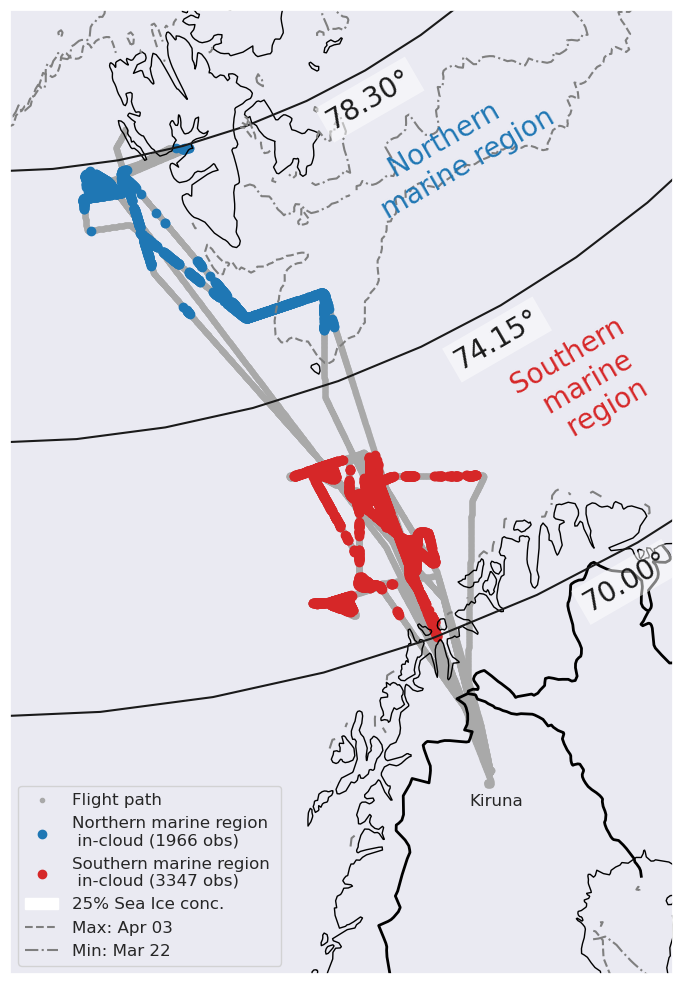

In [ ]:
# --- Split for southern marine, northern marine and land datasets (in cloud)

# --- plotting division areas
# Define latitudes to set as boundaries
lat_min = ds_incloud.lat.values.min() 
lat_max = ds_incloud.lat.values.max()
lat_mid = lat_min + ((lat_max-lat_min)/2) # separation point for the southern marine and northern marine

# set lat-bands to compute between (as an array)
lat_bands = [lat_min, lat_mid, lat_max]

# Get the mask to use to select northern and southern band data
lat_mask_north, lat_mask_south,set_val_count_dict = plots.lat_2band_select(lat_bands, ds_incloud)

# set the value of region based on the two masks
ds_incloud['region'] = xr.where(lat_mask_north, 'north', xr.where(lat_mask_south, 'south', 'none'))

# drop values where region is 'none'
no_region_mask = (ds_incloud['region']=='none').compute()
ds_incloud = ds_incloud.where(~no_region_mask, drop=True)

# plot this variant of latitude bands:
#plot_text = f'In-cloud observations \n (tot. {len(ds_incloud.time)} obs.) per region' #\n \
           # Preselection: {pre_text}\n \
            #in-cloud threshold method: {th_method}, threshold(s): {th}'
savefile = save_path + f'Latitude_bands_regions_{sample_rate}s_{th_method}{preopt}.png'
plot_lat_bands(lat_bands, ds, ds_incloud, sic_max_ds,sic_min_ds,'', savefile= savefile)

print(savefile)


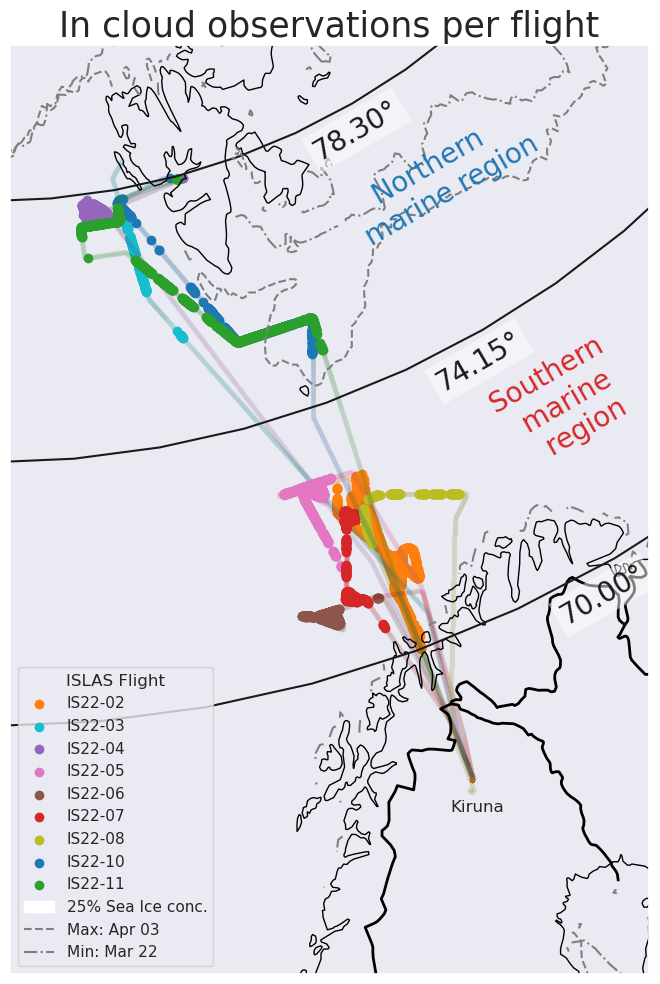

In [377]:
# Plot: incloud observations per flight

#savefile = save_path + f'Incloud_pr_flight_{min_date}.png' # testing different sea ice oconcentration files
savefile = save_path + f'Incloud_pr_flight_{sample_rate}s_{th_method}{preopt}.png'

plot_flight_obs(lat_bands, ds, ds_incloud,sic_max_ds, sic_min_ds, 'In cloud observations per flight', obs=True, savefile=savefile) #obs=true adds observations

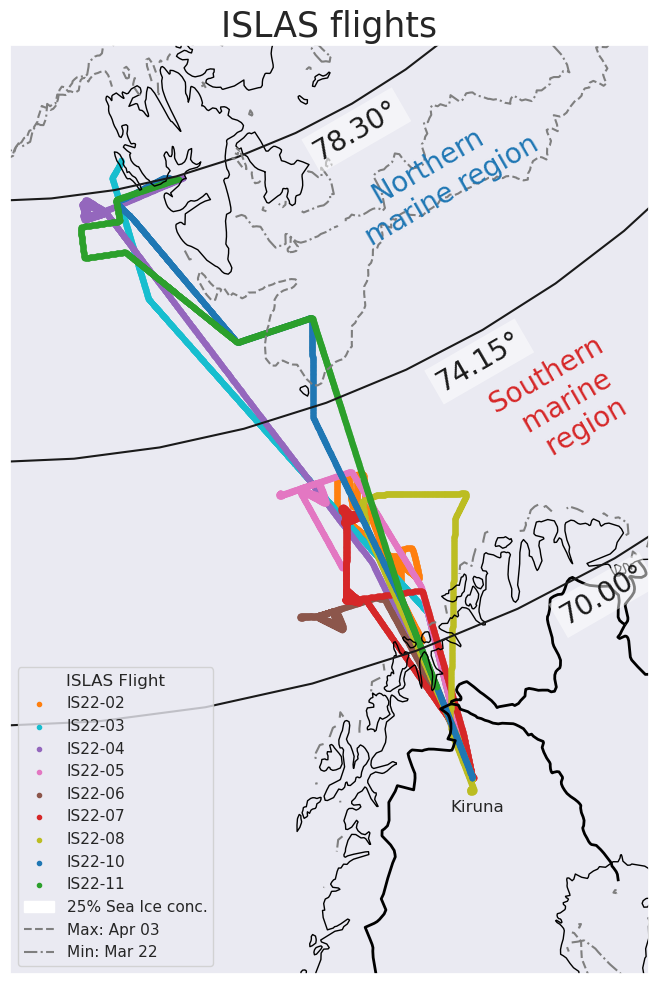

In [378]:
# Plot: flights from ISLAS campaign in use with sea ice concentration
savefile = save_path + f'Islas_flights_{sample_rate}s_{th_method}{preopt}.png'
plot_flight_obs(lat_bands, ds, ds_incloud,sic_max_ds, sic_min_ds, 'ISLAS flights', obs=False, savefile=savefile)

In [379]:
date_obj = pd.to_datetime(date, format='%Y%m%d')
date_obj.strftime('%b')


'Apr'

### Number concentration per region and per altitude band


In [380]:
# separate Northern and Southern Marine data
# - Northern marine
north_ds = ds_incloud.where(ds_incloud['region']=='north', drop = True)

# - Southern marine
south_ds = ds_incloud.where(ds_incloud['region']=='south', drop = True)



In [381]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs latitude bin

# lat_bands: holds the division lines between lat bands: min, middle, max (floats) 
lat_bins = np.arange(math.floor(lat_bands[0]), math.ceil(lat_bands[2])+1) # array of 1 deg lats from 70 to 79 (ints) 


count_df = create_counts(ds_incloud, lat_bins) # counts for incloud
count_rel_df = create_counts(ds_relevant, lat_bins) # counts for all non-cirrus data
# Calculating the percentage of total observations per category that is in cloud:
dist_df = ((count_df/count_rel_df)*100)

# check dfs:
#print(count_df)
#print(count_rel_df)
#print(dist_df)

In [382]:
#s_t_mean = south_ds.groupby('altitude_bin')['T'].mean()

south_ds

<xarray.Dataset> Size: 13MB
Dimensions:                 (time: 3347, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 27kB 2022-03-22T11:39:01 .....
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 13kB 70.2 70.22 70.23 ... 72.03 72.03
    lon                     (time) float32 13kB 20.38 20.37 ... 24.78 24.79
    alt                     (time) float32 13kB 3.863e+03 ... 2.032e+03
    islasid                 (time) <U7 94kB 'IS22-02' 'IS22-02' ... 'IS22-08'
    altitude_bin            (time) int64 27kB 3750 3750 3750 ... 1950 1950 1950
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/80)
    base_time               (time) datetime64[ns] 27kB 2022-03-22T11:37:21 .....
    utc_time                (time) float64 27kB dask.array<chunksize=(1771,), meta=np.ndarray>
    TAS                     (time) float32 13kB dask.array<chunksize=(1771,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 857kB dask.array<chunksize=(1771, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 13kB dask.array<chunksize=(1771,), meta=np.ndarray>
    SA                      (time, Vector64) float32 857kB dask.array<chunksize=(1771, 64), meta=np.ndarray>
    ...                      ...
    LWC corr                (time) float64 27kB dask.array<chunksize=(1771,), meta=np.ndarray>
    SV                      (time) float32 13kB dask.array<chunksize=(1771,), meta=np.ndarray>
    SV_CDP                  (time) float32 13kB dask.array<chunksize=(1771,), meta=np.ndarray>
    TWC                     (time) float64 27kB dask.array<chunksize=(1771,), meta=np.ndarray>
    SLF                     (time) float64 27kB dask.array<chunksize=(1771,), meta=np.ndarray>
    region                  (time) object 27kB 'south' 'south' ... 'south'
Attributes:
    date_modified:            2025-07-02
    Joint sample rate (sek):  5.0

/home/ninalar/Documents/MC2/procIslasMicrophy-1/save_images/sample_rate/Perc_incloud_alt_lat_5s_LWC_IWC_th.png


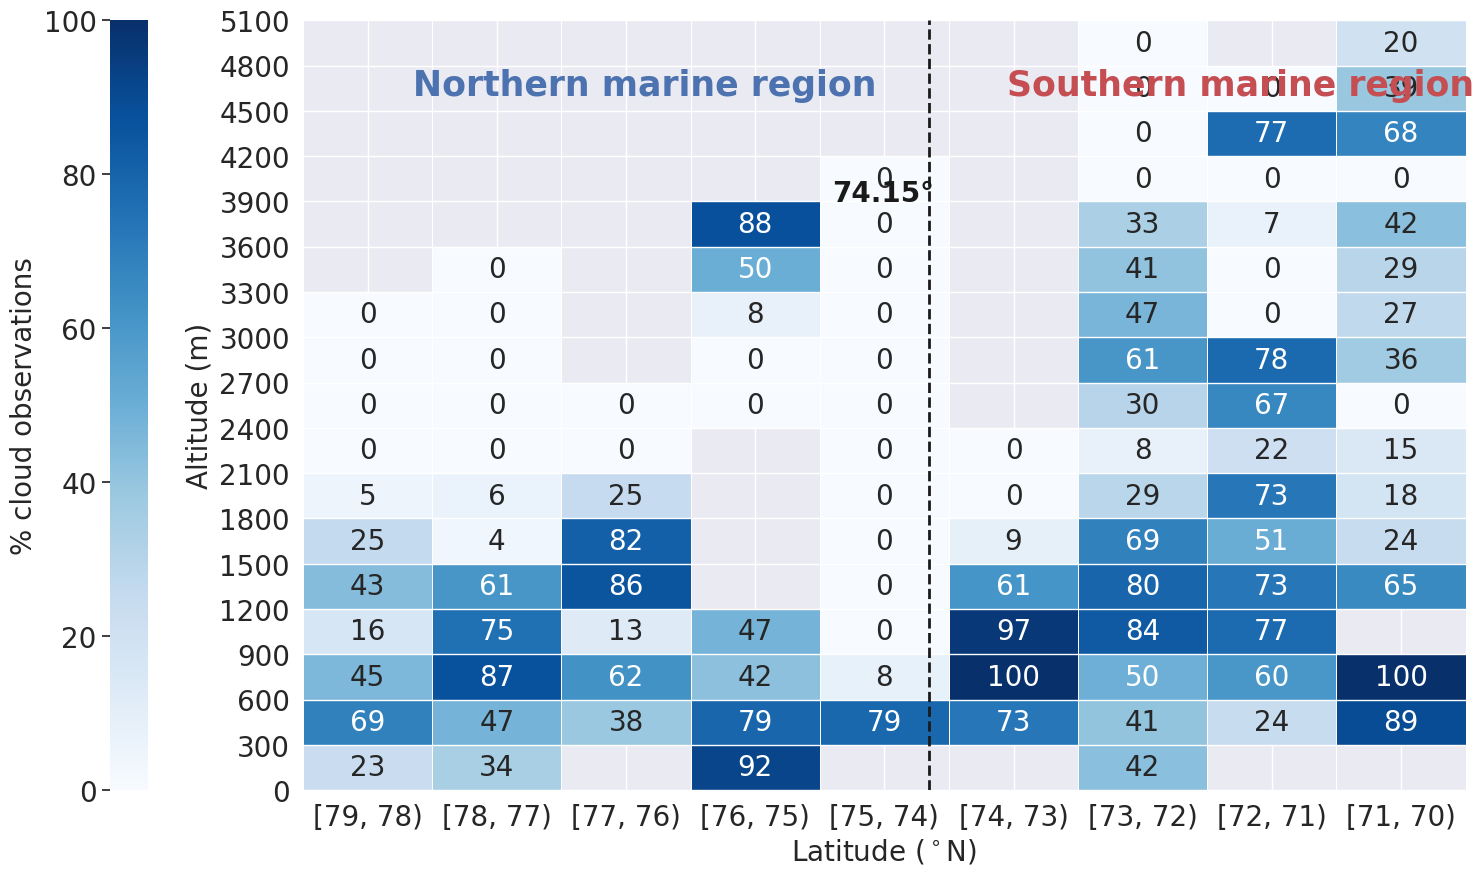

In [383]:
# Version 1: heatplot of percentage of observations that where in-cloud
# Without temperature

f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

pl = sns.heatmap(dist_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
            cbar_kws={"label": "% cloud observations", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)

pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('% cloud observations', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=45)

# add overlines
# Create overlay plot
ax_lines = f.add_axes(ax.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)


# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 4, 4600, 'Northern marine region', c='b', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] - 0.6, 4600, 'Southern marine region', c='r', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] + 0.75, 3900, f"{lat_bands[1]:.2f}°", weight='bold',c='k', fontsize=ss)

#plt.title(f'Percentage of in cloud observations per total obs per alt_bin vs. lat_bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}')
#plt.title(f'Percentage of in cloud observations \n per total obs per alt_bin vs. lat_bin', fontsize=20)
plt.savefig(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png', bbox_inches='tight')

print(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png')

(0.0, 5100.0)

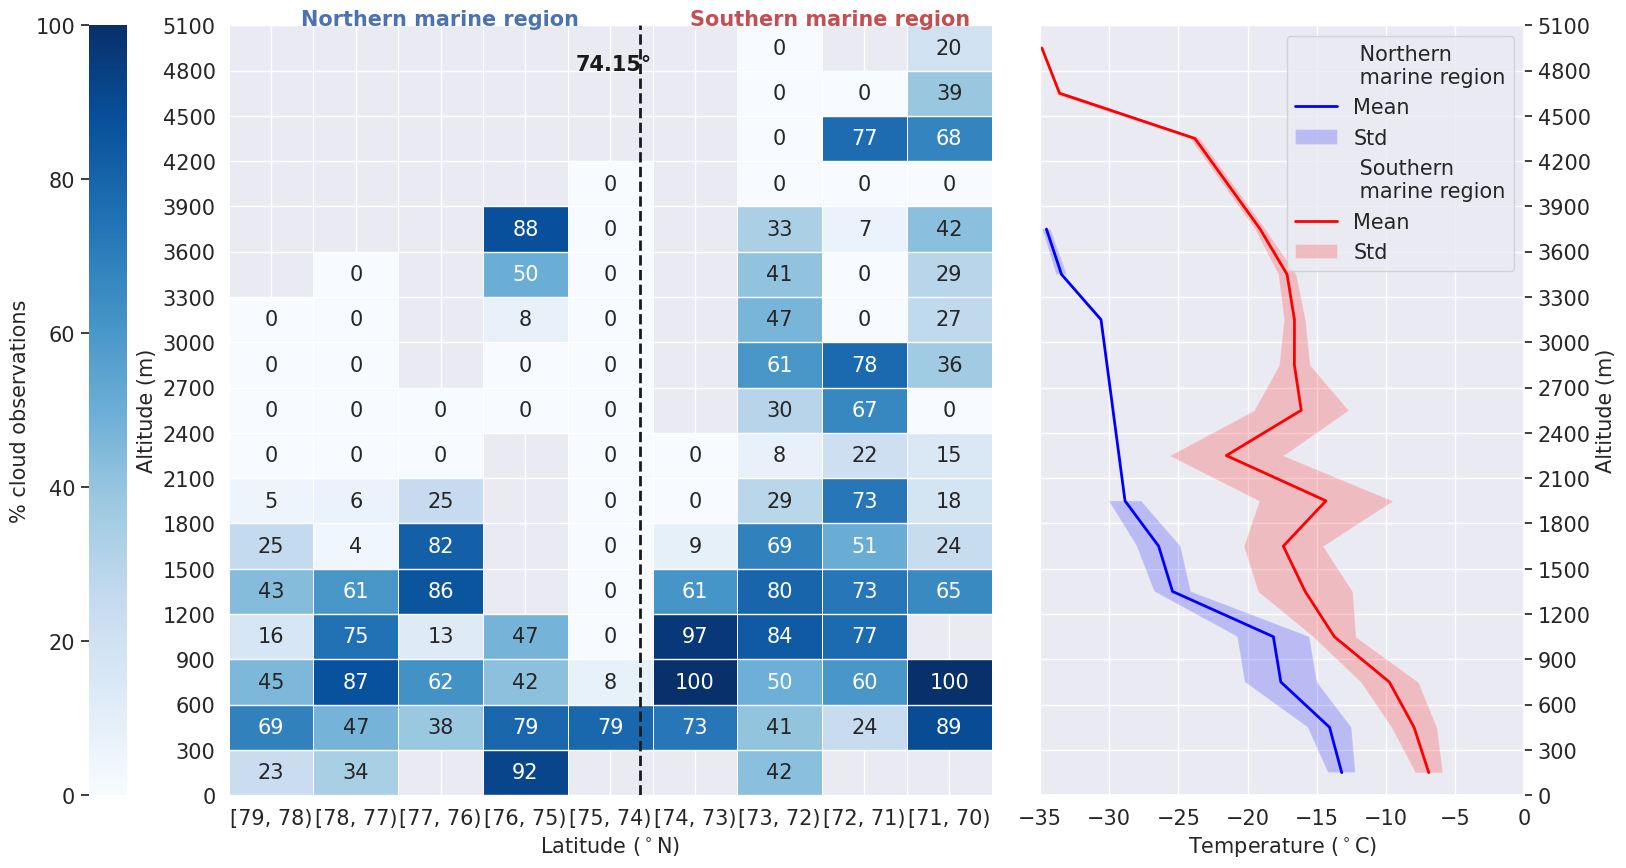

In [ ]:
# Version 2: heatplot of percentage of observations that where in-cloud
# With temperature


# Set up the figure with Gridspec
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3, wspace=0.1)  # 1 row, 3 columns

# Create the heatmap on the left (2/3 of the width)
ax_heatmap = fig.add_subplot(gs[:, :2])

#plot text size options
hs=15
ss=15


pl = sns.heatmap(dist_df, annot=True, fmt=".0f", cmap='Blues', ax=ax_heatmap, 
            cbar_kws={"label": "% cloud observations", "location" : "left"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)

pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('% cloud observations', fontsize=ss)  # Change colorbar label size


# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=45)

# add overlines
# Create overlay plot
ax_lines = fig.add_axes(pl.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)


# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 4, 5100, 'Northern marine region', c='b', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] - 0.6, 5100, 'Southern marine region', c='r', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] + 0.75, 4800, f"{lat_bands[1]:.2f}°", weight='bold',c='k', fontsize=ss)

ax_temp = fig.add_subplot(gs[:,2])

# Temperature southern and northern marine
# -- southern marine: mean and std
# Select variables to plot
sel_vars = ['altitude_bin', 'T']

south_df = south_ds[sel_vars].to_dataframe().reset_index()
s_t_mean = south_df.groupby('altitude_bin')['T'].mean()
s_t_std = south_df.groupby('altitude_bin')['T'].std()

# -- northern marine: mean and std
north_df = north_ds[sel_vars].to_dataframe().reset_index()
n_t_mean = north_df.groupby('altitude_bin')['T'].mean()
n_t_std = north_df.groupby('altitude_bin')['T'].std()

# the comma is to get the first element of the list returned
nmn, = ax_temp.plot(n_t_mean, n_t_mean.index, label = 'Northern \n marine region \n mean', lw=2,color = 'blue')
nstd = ax_temp.fill_betweenx(n_t_mean.index, n_t_mean+n_t_std, n_t_mean-n_t_std, facecolor='blue', alpha=0.2, label='N.M.R. std')

smn, = ax_temp.plot(s_t_mean, s_t_mean.index, label = 'Southern \n marine region \n mean', lw=2,color = 'red')
sstd = ax_temp.fill_betweenx(s_t_mean.index, s_t_mean+s_t_std, s_t_mean-s_t_std, facecolor='red', alpha=0.2, label='S.M.R. std')


# Create to title legend
legend_handles = [nmn, nstd, smn, sstd]
legend_labels = ['Mean', 'Std', 'Mean', 'Std']

# Create a legend with titles and custom handles
from matplotlib.lines import Line2D

# Create custom legend handles for the two titles
title1 = Line2D([0], [0], color='none', label=' Northern \n marine region', lw=0)  # Empty handle for title
title2 = Line2D([0], [0], color='none', label=' Southern \n marine region', lw=0)  # Empty handle for title

# Combine the handles and labels
handles = [title1] + [legend_handles[0], legend_handles[1], title2, legend_handles[2], legend_handles[3]]
labels = [title1.get_label(),legend_labels[0], legend_labels[1], title2.get_label(), legend_labels[2], legend_labels[3]]

# Add legend to the plot
ax_temp.legend(handles=handles, labels=labels, loc='upper right', fontsize=ss)

ax_temp.tick_params(axis='both', which='major', labelsize=ss)
ax_temp.set_ylabel('Altitude (m)', fontsize = ss)
ax_temp.yaxis.set_label_position("right")
ax_temp.set_xlabel('Temperature ($^\circ$C)', fontsize = ss)
ax_temp.set_xlim([-35, 0])

ax_temp.yaxis.tick_right()
ax_temp.set_yticks(altitude_bins)
ax_temp.set_ylim([0,5100])

#plt.title(f'Percentage of in cloud observations per total obs per alt_bin vs. lat_bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}')
#plt.title(f'Percentage of in cloud observations \n per total obs per alt_bin vs. lat_bin', fontsize=20)
#plt.savefig(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png', bbox_inches='tight')

#print(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}.png')

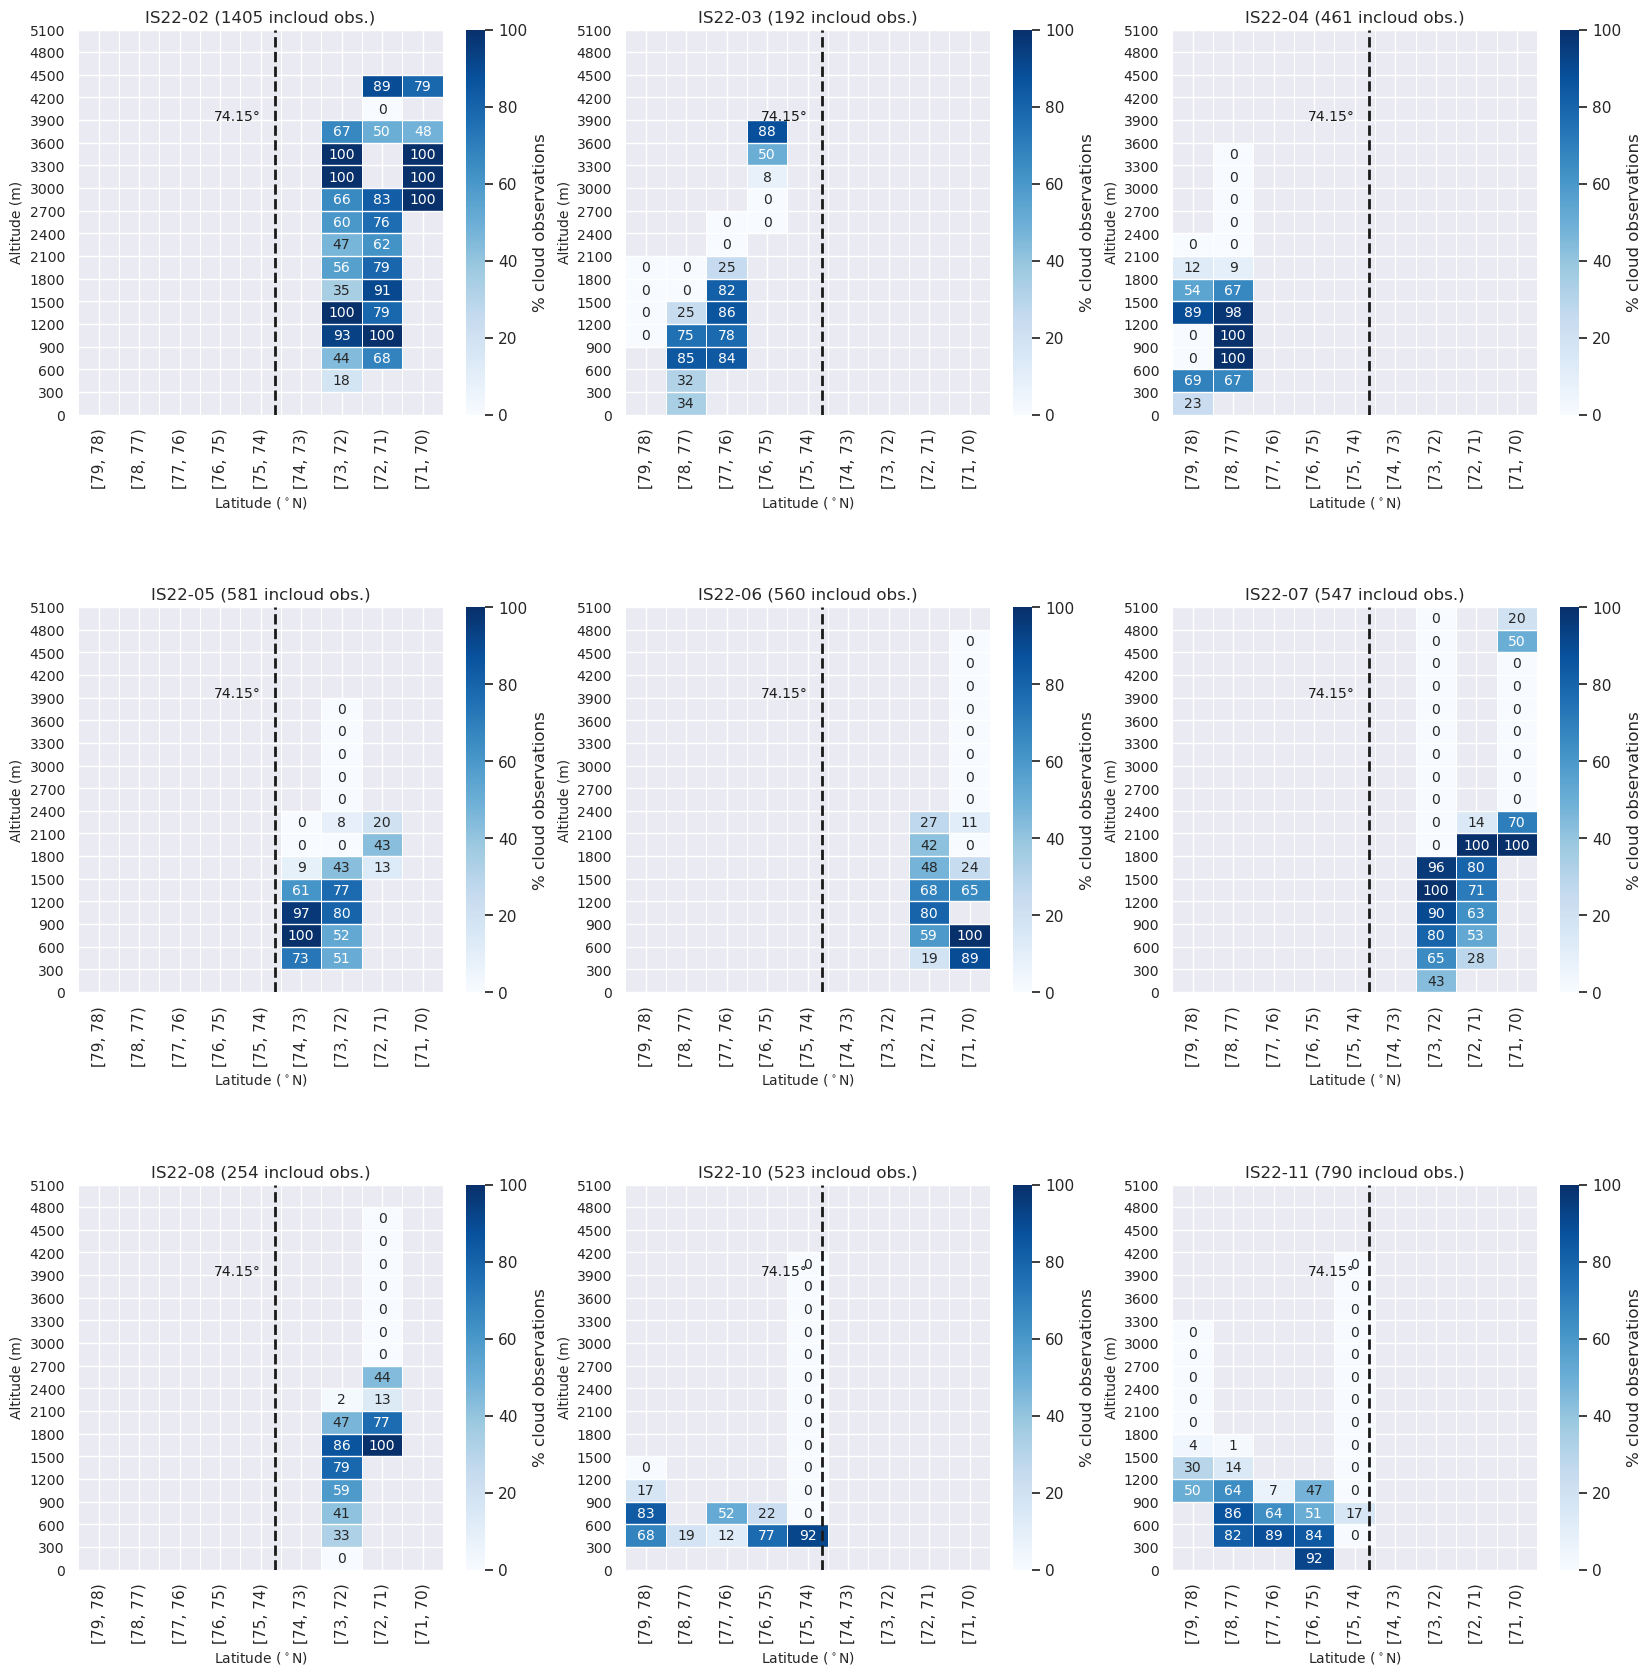

In [ ]:
# make the distribution plots per flight
# heatplot of percentage of observations that where in-cloud
f, axs = plt.subplots(3,3,figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

ids = np.unique(ds_incloud.islasid.values)

for islasid, ax in zip(ids, axs.ravel()):
    #filter the two main dataframes on the flight
    ds_incloud_flight = ds_incloud.where(ds_incloud['islasid']==islasid, drop = True)
    ds_relevant_flight = ds_relevant.where(ds_relevant['islasid']==islasid, drop = True)
    
    # create dataframe with the data to visualize in the separate plots:
    # lat_bins is the same as for the full dataset
    
    count_df = create_counts(ds_incloud_flight, lat_bins) # counts for incloud selection
    count_rel_df = create_counts(ds_relevant_flight, lat_bins) # counts for all observations
    # Calculating the percentage of total observations per category that is in cloud:
    dist_df = ((count_df/count_rel_df)*100)

    #plot text size options
    hs=15
    ss=10
    #i = 0
    #j = 0
    pl = sns.heatmap(dist_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
                cbar_kws={"label": "% cloud observations"},
                linewidths=0.5, annot_kws={'size':ss}, vmin=0, vmax = 100)
    
    ax.set_title(f'{islasid} ({len(ds_incloud_flight.time)} incloud obs.)')
    
    pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
    pl.set_ylabel('Altitude (m)', fontsize=ss)
    pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

    # add overlines
    # Create overlay plot
    ax_lines = f.add_axes(ax.get_position(), frameon=False)
    ax_lines.set_xlim(79,70)
    ax_lines.set_ylim(0,4500)
    yticks = np.linspace (0,4500,300)
    ax_lines.set_yticks(altitude_bins)
    ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
    ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
    ax_lines.tick_params(labelsize=ss)

    # Plot the limit between the two regions
    ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
    #ax_lines.text(lat_bands[1] + 4.8, 0, 'Northern marine region', c='b', rotation = 90, fontsize=hs)
    #ax_lines.text(lat_bands[1] - 4.1, 0, 'Southern marine region', c='r', rotation = 90, fontsize=hs)
    ax_lines.text(lat_bands[1] + 1.5, 3900, f"{lat_bands[1]:.2f}°",c='k', fontsize=ss)

plt.savefig(save_path + f'Perc_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}_singleflights.png', bbox_inches='tight')

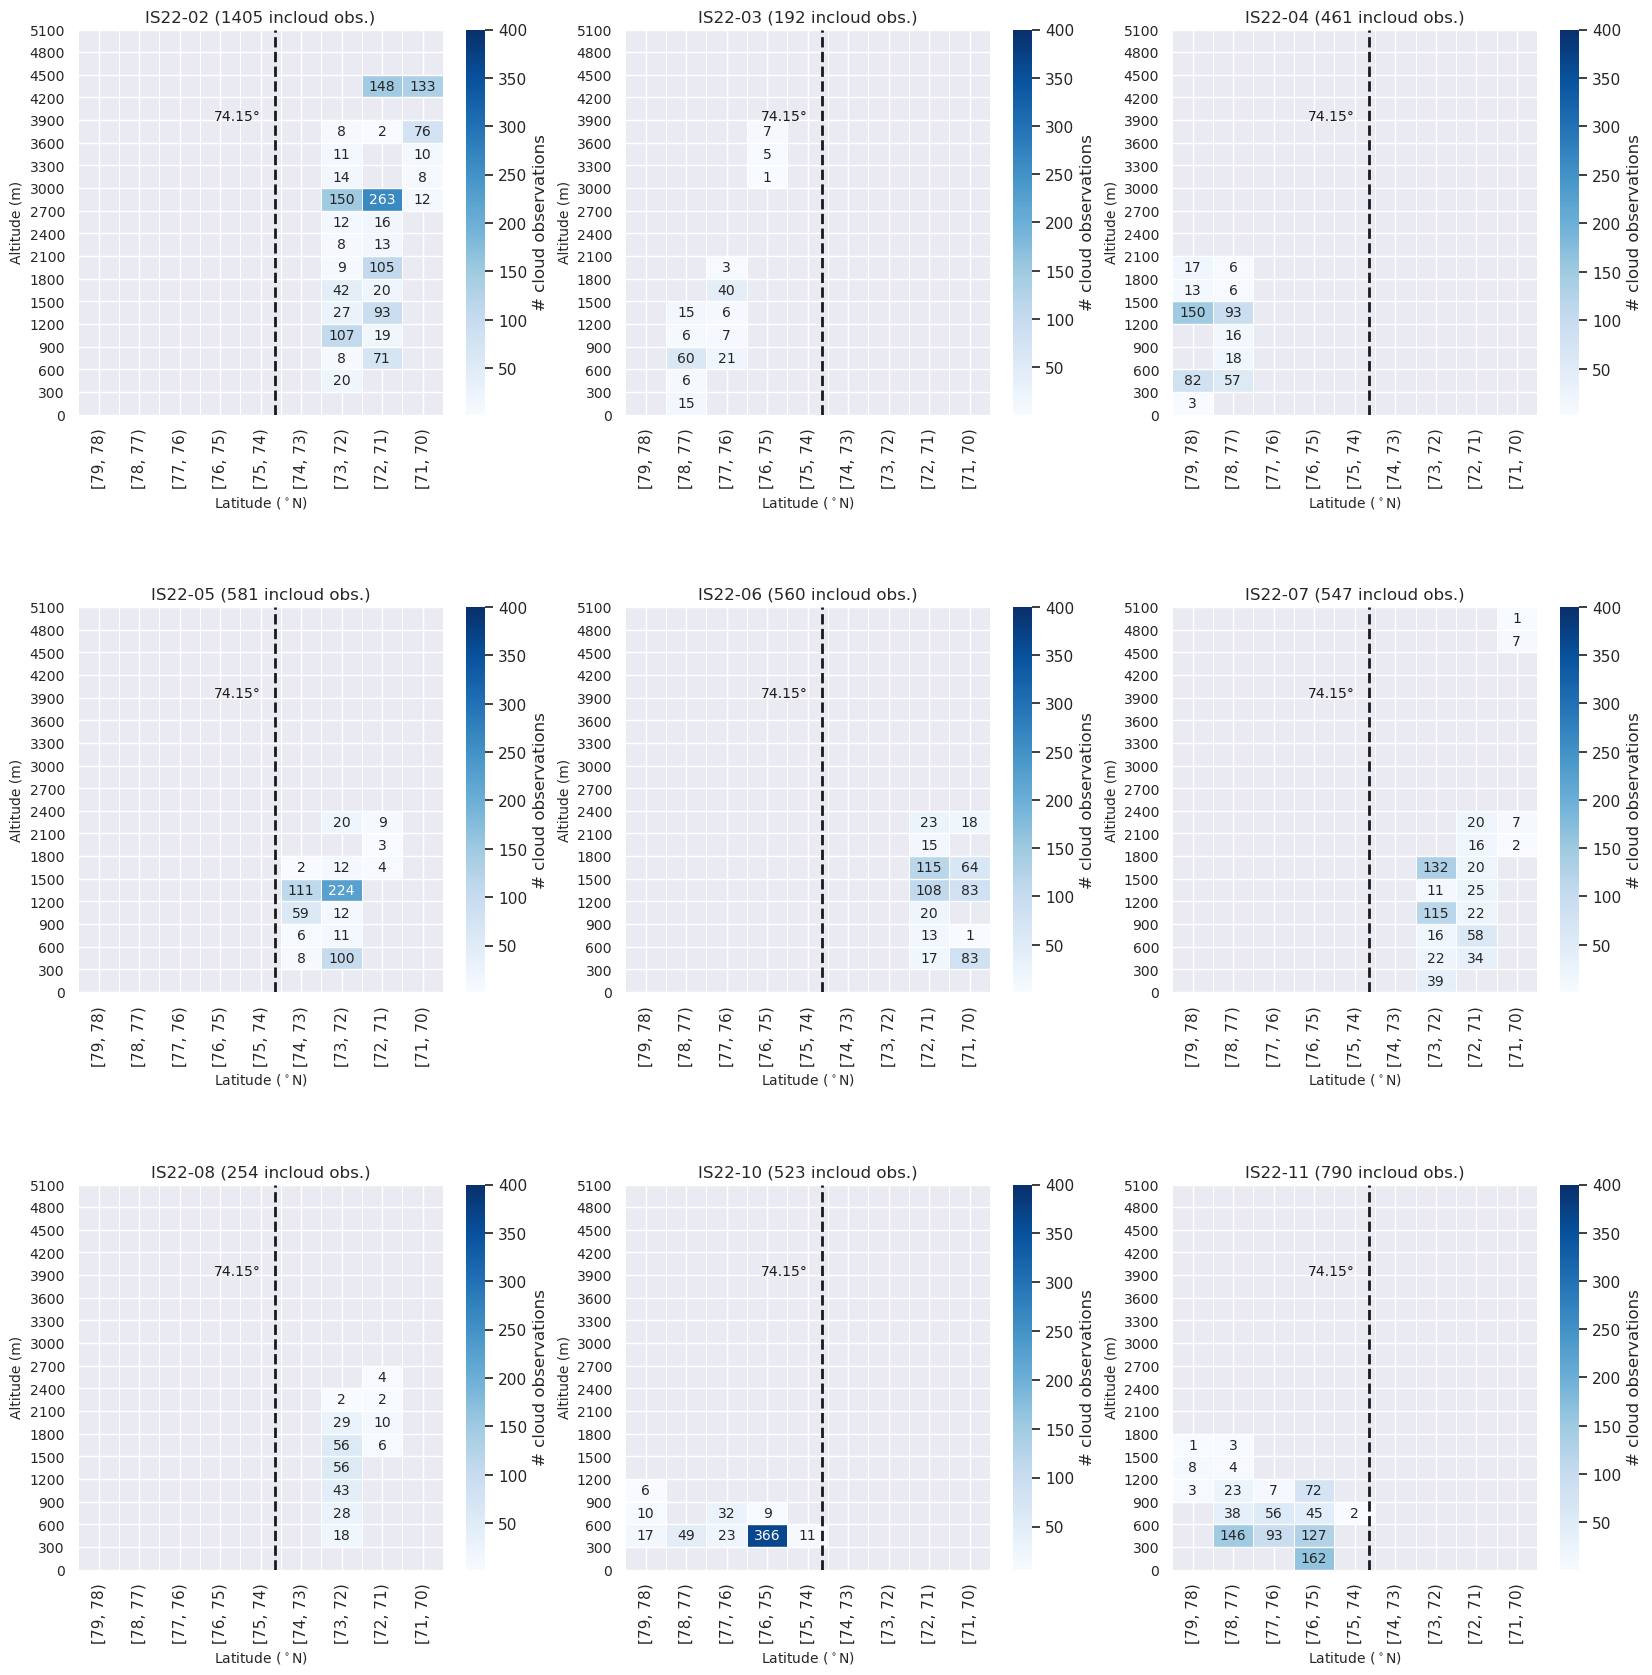

In [ ]:
# make the distribution plots per flight
# heatplot of number of observations that where in-cloud
f, axs = plt.subplots(3,3,figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

ids = np.unique(ds_incloud.islasid.values)

for islasid, ax in zip(ids, axs.ravel()):
    #filter the two main dataframes on the flight
    ds_incloud_flight = ds_incloud.where(ds_incloud['islasid']==islasid, drop = True)
    ds_relevant_flight = ds_relevant.where(ds_relevant['islasid']==islasid, drop = True)
    
    # create dataframe with the data to visualize in the separate plots:
    # lat_bins is the same as for the full dataset
    
    count_df = create_counts(ds_incloud_flight, lat_bins) # counts for incloud selection
    #set 0 to nan
    count_df = count_df.replace(0,np.nan)
    
    count_rel_df = create_counts(ds_relevant_flight, lat_bins) # counts for all observations
    # Calculating the percentage of total observations per category that is in cloud:
    dist_df = ((count_df/count_rel_df)*100)

    #plot text size options
    hs=15
    ss=10
    #i = 0
    #j = 0
    pl = sns.heatmap(count_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
                cbar_kws={"label": "# cloud observations"},
                linewidths=0.5, annot_kws={'size':ss}, vmax=400)
    
    ax.set_title(f'{islasid} ({len(ds_incloud_flight.time)} incloud obs.)')
    
    pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
    pl.set_ylabel('Altitude (m)', fontsize=ss)
    pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

    # add overlines
    # Create overlay plot
    ax_lines = f.add_axes(ax.get_position(), frameon=False)
    ax_lines.set_xlim(79,70)
    ax_lines.set_ylim(0,4500)
    yticks = np.linspace (0,4500,300)
    ax_lines.set_yticks(altitude_bins)
    ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
    ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
    ax_lines.tick_params(labelsize=ss)

    # Plot the limit between the two regions
    ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
    #ax_lines.text(lat_bands[1] + 4.8, 0, 'Northern marine region', c='b', rotation = 90, fontsize=hs)
    #ax_lines.text(lat_bands[1] - 4.1, 0, 'Southern marine region', c='r', rotation = 90, fontsize=hs)
    ax_lines.text(lat_bands[1] + 1.5, 3900, f"{lat_bands[1]:.2f}°",c='k', fontsize=ss)

plt.savefig(save_path + f'Count_incloud_alt_lat_{sample_rate}s_{th_method}{preopt}_singleflights.png', bbox_inches='tight')

In [ ]:
len(ds_incloud.time)

In [ ]:
# --- Prep-work for other plots

# Select variables to plot
sel_vars = ['TWC','IWC100', 'LWC corr','SLF', 'region', 'altitude_bin', 'T']

# creating dataframes for easier reuse of plots
north_df = north_ds[sel_vars].to_dataframe().reset_index()
south_df = south_ds[sel_vars].to_dataframe().reset_index()

In [ ]:
north_df

In [ ]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs SLF bin

def create_counts_slf(df, bin_labels, vert_param, Tbin = 2, norm=True):
    # Function to create counts array of the slf-data against either temperature or altitude
    # To use when making heatmaps. Keeps control of normalizations etc.
    # Input: 
    # --- df: dataframe with all data
    # --- bins_labels: total altitude bins (calculated earlier, not needed if temperature is used)
    # --- Vert_param: the vertical parameter to do he calculations on. either 'alt' or'T'
    # --- Tbin: degrees to bin temperature in
    # --- norm = True: if normalization per vertical layer should be done.
    # output:
    # --- count_df: df of number of observations per SLF bin and altitude bin/temperature bin for the given dataset
    
    # Calculate SLF bins:
    slf_bins = np.arange(0,105, 5) # slf_bins: create a set of 20 bins from 0 to 100% 
    df['SLF_bins'] = pd.cut(df['SLF'], bins=slf_bins, right=True, include_lowest=False) # bin the SLF data

    # calculate grouped data for the given vert_param
    if vert_param =='alt':
        grouped_data = df.groupby(['SLF_bins', 'altitude_bin'], observed = True).size() # group by both binning variables
        # Adjustments
        count_df = grouped_data.reset_index(name='counts') # convert to dataframe
        count_df = count_df.pivot(index='altitude_bin', columns='SLF_bins', values='counts')#.fillna(0) #pivot to get SLF on corrext axis
        count_df = count_df.reindex(bin_labels) # reindex to make sure all altitude_bins are included
        count_df = count_df.iloc[::-1] # reverse altitude order
    elif vert_param =='T':
        T_bins = np.arange(-35,-5,Tbin) # T_bins: from -35 to -5 in degre bins given (default 2)
        df['T_bins'] = pd.cut(df['T'], bins=T_bins, right=True, include_lowest=False) # bin the T data
        grouped_data = df.groupby(['SLF_bins', 'T_bins'], observed = True).size() # group by both binning variables
        # Adjustments
        count_df = grouped_data.reset_index(name='counts') # convert to dataframe
        count_df = count_df.pivot(index='T_bins', columns='SLF_bins', values='counts')#.fillna(0) #pivot to get SLF on corrext axis
        count_df = count_df.reindex(T_bins) # reindex to make sure all altitude_bins are included
   

    # normalize by altitude if chosen
    if norm: 
        print('Normalize!')
        sum_alt = count_df.sum(axis=1)
        normalized_count_df = count_df.div(sum_alt, axis=0)*100
        return normalized_count_df, count_df
    else:
        print('no normalization ...')
        # Return counts as integers
        return count_df
    

nnormcount_df, ncount_df = create_counts_slf(north_df, bin_labels, 'alt')
snormcount_df, scount_df = create_counts_slf(south_df, bin_labels, 'alt')


In [ ]:
## SINGLE MARGPLOT ALTITUDE Code that works

def slf_marg_plot_alt(df, title, altitude_bins,bin_labels, x_bins=20, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    from matplotlib.colors import LogNorm
    import numpy as np

    #plot text size options
    hs=25
    ss=20
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")

    # preparing for histogram and 2d histogram
    # create a count_df for heatmap plot
    norm_count_df, count_df = create_counts_slf(df, bin_labels, 'alt')
  
    vert_df = count_df.sum(axis=1)
   
    fig = plt.figure(figsize=(25,15))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of obs.: \n{len(df)}', size=ss)

    hh = sns.heatmap(norm_count_df, cmap='Blues', ax=ax_main, annot=True, fmt=".0f", annot_kws={"fontsize":ss},
            cbar_kws={"label": "% of Observations","location":"left","pad":0.18}, vmin=0, vmax=100,
            linewidths=0.5, norm=LogNorm())
    
    ax_main.set_ylabel('Altitude (m)', fontsize = hs)
    ax_main.set_xlabel('SLF %', fontsize = hs)
    xlabel = [interval.right for interval in norm_count_df.sum(axis=0).index] # get the highest number from the interval
    xlabel = [int(num) for num in xlabel] # turn into int
    ax_main.set_xticklabels(xlabel)
    ax_main.tick_params('x',rotation=0)

    #colorbar adjustments:
    cbar = ax_main.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ss) #change label textsize
    cbar.set_label(label = "% of Observations \n per 300 m altitude", fontsize=ss)

    # Marginal histograms
    # set the horizontal histogram
    horiz = norm_count_df.sum(axis=0)
    bin_edges = [interval.left for interval in horiz.index] + [horiz.index[-1].right]
    # normalize the horiz values
    horiz_sum = horiz.sum()
    norm_horiz = horiz/horiz_sum
    heights = norm_horiz.values.tolist()  # Get the values as a list

    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights)
    ax_xDist.set_ylabel('Norm. count', fontsize = ss)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_ylim(0,0.8)
    ax_xDist.set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])
    ax_xDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_xDist.tick_params(axis='both', which='minor', labelsize=ss)

    # set the vertical histogram
    vert = count_df.sum(axis=1)
    vert.sort_index(inplace=True)
    bin_edges = [0] + vert.index.tolist()
    heights = vert.values.tolist()  # Get the values as a list
    
    ax_yDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights, orientation='horizontal')
    ax_yDist.set_xlabel('# obs \n pr 300 m', fontsize = ss)
    ax_yDist.yaxis.tick_right()
    ax_yDist.set_ylim(-150,4350) # if alt
    #ax_yDist.set_ylim(-5,-35) # if T
    ax_yDist.set_yticks(bin_edges[1:])
    ax_yDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_yDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])

    # ticklabel adjustments
    xlab = ax_main.get_xticklabels() 
    ax_main.set_xticklabels(labels = xlab, size=ss)
    ylab = ax_main.get_yticklabels()
    for label in ylab:
        label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
    ax_main.set_yticklabels(labels = ylab, size = ss, rotation=0)
    
    plt.suptitle(title, fontsize = 30)
    
    return(fig)


s_plot = slf_marg_plot_alt(south_df, f'b) Southern marine region (sample rate:{sample_rate}s)', altitude_bins, bin_labels)
s_plot.savefig(save_path+f'SLF_alt_South_{sample_rate}s_{th_method}{preopt}.png') # Save to
n_plot = slf_marg_plot_alt(north_df, f'a) Northern marine region(sample rate:{sample_rate}s)', altitude_bins, bin_labels)
n_plot.savefig(save_path+f'SLF_alt_North_{sample_rate}s_{th_method}{preopt}.png') # Save to

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (as provided)
data = {
    -35: 0.0,
    -33: 0.0,
    -31: 0.0,
    -29: 0.0,
    -27: 0.0,
    -25: 32.0,
    -23: 323.0,
    -21: 64.0,
    -19: 388.0,
    -17: 676.0,
    -15: 570.0,
    -13: 641.0,
    -11: 134.0,
    -9: 347.0,
    -7: 273.0,
}

# Convert it to a Series (like the original data structure)
T_bins = pd.Series(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(test.index, test.values, height=2, color='blue', alpha=0.7)  # Use barh for horizontal bar plot

# Customizing the plot
plt.title('Histogram of Temperature Counts', fontsize=20)
plt.ylabel('Temperature (°C)', fontsize=16)
plt.xlabel('Frequency', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Invert the y-axis so -35 is at the top
plt.gca().invert_yaxis()

plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
## SINGLE MARGPLOT Temperature testing

def slf_marg_plot_alt(norm_count_df, count_df,df, title, altitude_bins, max_obs, bin_labels, x_bins=20, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    from matplotlib.colors import LogNorm
    import numpy as np

    #plot text size options
    hs=25
    ss=20
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")
  
    vert_df = count_df.sum(axis=1)
   
    fig = plt.figure(figsize=(25,15))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    #plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of obs.: \n{len(df)}', size=ss)

    hh = sns.heatmap(norm_count_df, cmap='Blues', ax=ax_main, annot=True, fmt=".0f", annot_kws={"fontsize":ss},
            cbar_kws={"label": "% of Observations","location":"left","pad":0.18}, vmin=0, vmax=100,
            linewidths=0.5, norm=LogNorm())
    
    ax_main.set_ylabel('Temperature ($^\circ$C)', fontsize = hs)
    ax_main.set_xlabel('SLF %', fontsize = hs)
    xlabel = [interval.right for interval in norm_count_df.sum(axis=0).index] # get the highest number from the interval
    xlabel = [int(num) for num in xlabel] # turn into int
    ax_main.set_xticklabels(xlabel)
    ax_main.tick_params('x',rotation=0)

    #colorbar adjustments:
    cbar = ax_main.collections[0].colorbar
    cbar.ax.tick_params(labelsize=ss) #change label textsize
    cbar.set_label(label = f'% of Observations \n per {tbin}$^\circ$C', fontsize=ss)

    # Marginal histograms
    # set the horizontal histogram
    horiz = norm_count_df.sum(axis=0)
    bin_edges = [interval.left for interval in horiz.index] + [horiz.index[-1].right]
    # normalize the horiz values
    horiz_sum = horiz.sum()
    norm_horiz = horiz/horiz_sum
    heights = norm_horiz.values.tolist()  # Get the values as a list
    
    ax_xDist.hist(bin_edges[:-1],bins = bin_edges, weights= heights)
    ax_xDist.set_ylabel('Norm. count', fontsize = ss)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_ylim(0,0.8)
    ax_xDist.set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])
    ax_xDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_xDist.tick_params(axis='both', which='minor', labelsize=ss)
    
    # set the vertical histogram
    vert = count_df.sum(axis=1) # number of observations per vertical bin (temp/alt)
    #print(vert)
    vert.sort_index(inplace=True)
    bin_edges = vert.index.tolist()
    heights = vert.values.tolist()  # Get the values as a list
     
    ax_yDist.barh(vert.index, vert.values, height=4, alpha=0.7)
    ax_yDist.set_xlabel(f'# obs \n per {tbin}$^\circ$C', fontsize = ss)
    ax_yDist.yaxis.tick_right()
    ax_yDist.yaxis.set_inverted(True)
    #ax_yDist.set_ylim(-150,4350) # if alt
    #ax_yDist.set_ylim(-6,-35) # if T
    ax_yDist.set_xlim(0,max_obs)
    ax_yDist.set_yticks(bin_edges[1:])
    ax_yDist.tick_params(axis='both', which='major', labelsize=ss)
    ax_yDist.tick_params(axis='both', which='minor', labelsize=ss)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])

    # obs per 1 degree temperature line
    T_val = df['T'].values                                        # Get the temperature values
    T_val_round = np.round(T_val)                                       # round to whole numbers
    T_val_unique, counts = np.unique(T_val_round, return_counts=True)   # count the unique values in the array
    ax_yDist.plot(counts, T_val_unique, label='# obs per 1$^\circ$C')
    ax_yDist.legend()

    
    # ticklabel adjustments
    xlab = ax_main.get_xticklabels() 
    ax_main.set_xticklabels(labels = xlab, size=ss)
    ylab = ax_main.get_yticklabels()
    for label in ylab:
        label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
    ax_main.set_yticklabels(labels = ylab, size = ss, rotation=0)
    
    plt.suptitle(title + f', {len(df)} obs.', fontsize = 36)
    
    return fig

# preparing for histogram and 2d histogram
# create a count_df for heatmap plot
tbin = 4 # temperature bin size
    
#Make counts for both regions:
s_norm_count_df, s_count_df = create_counts_slf(south_df, bin_labels, 'T', Tbin=tbin)
n_norm_count_df, n_count_df = create_counts_slf(north_df, bin_labels, 'T', Tbin=tbin)

#find highest number of observations per temperaturebin for the two regions (to use as xlim)
max_obs = round(max([s_count_df.sum(1).max(),s_count_df.sum(1).max()]),-3)


s_plot = slf_marg_plot_alt(s_norm_count_df, s_count_df,south_df, f'b) Southern marine region (sample rate:{sample_rate}s)', altitude_bins,max_obs, bin_labels)
s_plot.savefig(save_path+f'SLF_T_South_{sample_rate}s_{th_method}{preopt}.png') # Save to
n_plot = slf_marg_plot_alt(n_norm_count_df, n_count_df,north_df, f'a) Northern marine region (sample rate:{sample_rate}s)', altitude_bins,max_obs, bin_labels)
n_plot.savefig(save_path+f'SLF_T_North_{sample_rate}s_{th_method}{preopt}.png') # Save to


In [ ]:
T_val = south_df['T'].values                                        # Get the temperature values
T_val_round = np.floor(T_val)                                       # round to whole numbers
T_val_unique, counts = np.unique(T_val_round, return_counts=True) 
print(T_val_unique)
print(counts)
17+56+167

In [ ]:
vert = s_count_df.sum(axis=1) 
vert

In [ ]:
south_df['T_bins'].unique()

In [ ]:
a = south_df[south_df['T_bins'].isin([pd.Interval(-35.001, -31.0, closed='right')])]
b = south_df[south_df['T_bins'].isin([pd.Interval(-31.0,-27.0, closed='right')])]
c = south_df[south_df['T_bins'].isin([pd.Interval(-27.0, -23.0, closed='right')])]
d = south_df[south_df['T_bins'].isin([pd.Interval(-23.0, -19.0, closed='right')])]
e = south_df[south_df['T_bins'].isin([pd.Interval(-19.0, -15.0, closed='right')])]
f = south_df[south_df['T_bins'].isin([pd.Interval(-15.0, -11.0, closed='right')])]
g = south_df[south_df['T_bins'].isin([pd.Interval(-11.0, -7.0, closed='right')])]

In [ ]:
south_df[south_df['T']<-35]

In [ ]:
# -- BOXPLOT: Water content, original

# Define the dataframes and columns
row_titles = ['North marine','South marine']
dfs = [north_df, south_df]
var = ['TWC', 'IWC100','LWC corr']

# Get list of all available altitude categories in the full dataset
alt_cats = np.unique(ds_incloud['altitude_bin'].values)

# subplotsize
n_rows = len(var)

fig, ax = plt.subplots(2, n_rows, figsize=(15, 12))


# Plot the data and add the count of observations
for col, df in enumerate(dfs):
    alt_bins = df['altitude_bin'].unique()
    positions = [np.where(alt_cats == alt)[0][0] + 1 for alt in alt_bins]
    for row, v in enumerate(var):
        df.boxplot(column= v, by='altitude_bin', ax=ax[col, row], positions=positions, vert=False, showfliers=False)
        ax[col, row].set_yticks(range(1, len(alt_cats) + 1))
        ax[col, row].set_yticklabels(alt_cats)

        if col == len(var) - 1:
            # Add counts only to the last plot
            counts = df['altitude_bin'].value_counts() #get the number of observations per altitude bin
            for group, count in counts.items():
                # for each item in the counts per altitude bin:
                # 1: find out where it is located in the array of sorted altitude bins
                # 2: plot the count as text by the boxplot located at this location.
                index_of_group = np.where(alt_cats==group)[0] +1  # change from 0 base to 1 base
                ax[row,0].text(1, index_of_group, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
           

# Set titles for each row
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes, fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
plt.setp(ax, xlim=(0, 1.2))
#plt.setp(ax, xlim=(0, 3.5)) # lims for showfliers = True


# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/LWC_IWC_TWC_per_lat_region_{th_method}{preopt}.png') # Save to
plt.show()


In [ ]:
ds_incloud['T'].attrs

In [ ]:
# -- BOXPLOT: Total water content and SLF


import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,2, figsize=(20, 15))

twc_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,99), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=False)
slf_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='SLF_all', hue='region', whis=(0,99), gap=.2, 
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=False)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

twc_p.set(xlabel=f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})", ylabel="Altitude bins (pr 300 m)")
slf_p.set(xlabel=f"Supercooled Liquid Fraction, LWC/TWC (%)", ylabel="Altitude bins (pr 300 m)")
#plt.setp(ax, xlim=(-0.01, 3.5))  

# --- Figure 
plt.suptitle(f'Vertical distributions of TWC and SLF divided by latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERS_seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
# -- BOXPLOT: Total water content
import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 15))

twc_p = sns.boxplot(data = ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,95), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax,
           showfliers=False)

ax.set_ylim(reversed(twc_p.get_ylim()))  # Reversing the y-axis for each subplot

# titles and adjust fontzises
twc_p.axes.set_title(f'Vertical distributions of TWC per region',fontsize=20)
twc_p.set_xlabel(f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})",fontsize=20)
twc_p.set_ylabel("Altitude (m)",fontsize=20)
twc_p.tick_params(labelsize=14)
plt.setp(twc_p.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(twc_p.get_legend().get_title(), fontsize='20')

# --- Figure 
#plt.suptitle(f'Vertical distributions of TWC pr region and 300 m altitude bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERSEGU_seaborn_TWC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
ds_incloud['test'] = ds_incloud['LWC corr']/ds_incloud['TWC']
ds_incloud['test']

In [ ]:
# -- BOXPLOT: Water contents, southern and northern in same plot (OLD)

import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(3,1, figsize=(8, 20))

sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='LWC corr', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='IWC100', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[2],
           showfliers=True)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

plt.setp(ax, xlim=(0, 3.5))  

# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
# -- southern marine
# get the mean values per height bin
s_twc_mean = south_df.groupby('altitude_bin')['TWC'].mean()
s_lwc_mean = south_df.groupby('altitude_bin')['LWC corr'].mean()
s_iwc_mean = south_df.groupby('altitude_bin')['IWC100'].mean()
s_t_mean = south_df.groupby('altitude_bin')['T'].mean() # temperature

# get the std values per height bin
s_twc_std = south_df.groupby('altitude_bin')['TWC'].std()
s_lwc_std = south_df.groupby('altitude_bin')['LWC corr'].std()
s_iwc_std = south_df.groupby('altitude_bin')['IWC100'].std()
s_t_std = south_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
s_twc_mx = south_df.groupby('altitude_bin')['TWC'].max()
s_lwc_mx = south_df.groupby('altitude_bin')['LWC corr'].max()
s_iwc_mx = south_df.groupby('altitude_bin')['IWC100'].max()
s_t_mx = south_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
s_twc_mn = south_df.groupby('altitude_bin')['TWC'].min()
s_lwc_mn = south_df.groupby('altitude_bin')['LWC corr'].min()
s_iwc_mn = south_df.groupby('altitude_bin')['IWC100'].min()
s_t_mn = south_df.groupby('altitude_bin')['T'].min()

# -- nothern marine
n_twc_mean = north_df.groupby('altitude_bin')['TWC'].mean()
n_lwc_mean = north_df.groupby('altitude_bin')['LWC corr'].mean()
n_iwc_mean = north_df.groupby('altitude_bin')['IWC100'].mean()
n_t_mean = north_df.groupby('altitude_bin')['T'].mean()

# get the std values per height bin
n_twc_std = north_df.groupby('altitude_bin')['TWC'].std()
n_lwc_std = north_df.groupby('altitude_bin')['LWC corr'].std()
n_iwc_std = north_df.groupby('altitude_bin')['IWC100'].std()
n_t_std = north_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
n_twc_mx = north_df.groupby('altitude_bin')['TWC'].max()
n_lwc_mx = north_df.groupby('altitude_bin')['LWC corr'].max()
n_iwc_mx = north_df.groupby('altitude_bin')['IWC100'].max()
n_t_mx = north_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
n_twc_mn = north_df.groupby('altitude_bin')['TWC'].min()
n_lwc_mn = north_df.groupby('altitude_bin')['LWC corr'].min()
n_iwc_mn = north_df.groupby('altitude_bin')['IWC100'].min()
n_t_mn = north_df.groupby('altitude_bin')['T'].min()

In [ ]:
# plotting the mean and the spread (std) per height


# plot the values
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(1,3, wspace=0)
axs = gs.subplots(sharey=True, sharex=True)

# TWC southern and northern marine
axs[0].plot(s_twc_mean, s_twc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[0].fill_betweenx(s_twc_mean.index, s_twc_mean+s_twc_std, s_twc_mean-s_twc_std, facecolor='red', alpha=0.2, label='S. std')

axs[0].plot(n_twc_mean, n_twc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[0].fill_betweenx(n_twc_mean.index, n_twc_mean+n_twc_std, n_twc_mean-n_twc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[0].set_title('TWC')
axs[0].set_ylabel('Altitude (m)')
axs[0].set_xlabel('g/m³')
axs[0].legend(loc='upper right')


# LWC southern and northern marine
axs[1].plot(s_lwc_mean, s_lwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[1].fill_betweenx(s_lwc_mean.index, s_lwc_mean+s_lwc_std, s_lwc_mean-s_lwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[1].plot(n_lwc_mean, n_lwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[1].fill_betweenx(n_lwc_mean.index, n_lwc_mean+n_lwc_std, n_lwc_mean-n_lwc_std, facecolor='blue', alpha=0.2, label='N.std')

axs[1].set_title('LWC')
axs[1].set_xlabel('g/m³')
axs[1].legend(loc='upper right')


# IWC southern and northern marine
axs[2].plot(s_iwc_mean, s_iwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[2].fill_betweenx(s_iwc_mean.index, s_iwc_mean+s_iwc_std, s_iwc_mean-s_iwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[2].plot(n_iwc_mean, n_iwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[2].fill_betweenx(n_iwc_mean.index, n_iwc_mean+n_iwc_std, n_iwc_mean-n_iwc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[2].set_title('IWC')
axs[2].set_xlabel('g/m³')
axs[2].legend(loc='upper right')


# --- Figure 
plt.suptitle(f'Mean water content per altitude, with standard deviation (separated by region) \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/mean_LWC_TWC_IWC_regionvise_{th_method}{preopt}.png') # Save to
plt.show()

In [ ]:
altitude_bins

In [ ]:
# mean temperature  per altitude per region, with standard deviation

# plot the values
fig, ax = plt.subplots(figsize=(8,8))

# Temperature southern and northern marine

# the comma is to get the first element of the list returned
nmn, = ax.plot(n_t_mean, n_t_mean.index, label = 'Northern \n marine region \n mean', lw=2,color = 'blue')
nstd = ax.fill_betweenx(n_t_mean.index, n_t_mean+n_t_std, n_t_mean-n_t_std, facecolor='blue', alpha=0.2, label='N.M.R. std')

smn, = ax.plot(s_t_mean, s_t_mean.index, label = 'Southern \n marine region \n mean', lw=2,color = 'red')
sstd = ax.fill_betweenx(s_t_mean.index, s_t_mean+s_t_std, s_t_mean-s_t_std, facecolor='red', alpha=0.2, label='S.M.R. std')


# Create to title legend
legend_handles = [nmn, nstd, smn, sstd]
legend_labels = ['Mean', 'Std', 'Mean', 'Std']

# Create a legend with titles and custom handles
from matplotlib.lines import Line2D

# Create custom legend handles for the two titles
title1 = Line2D([0], [0], color='none', label='Northern marine \n region', lw=0)  # Empty handle for title
title2 = Line2D([0], [0], color='none', label='Southern marine \n region', lw=0)  # Empty handle for title

# Combine the handles and labels
handles = [title1] + [legend_handles[0], legend_handles[1], title2, legend_handles[2], legend_handles[3]]
labels = [title1.get_label(),legend_labels[0], legend_labels[1], title2.get_label(), legend_labels[2], legend_labels[3]]

# Add legend to the plot
ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('Altitude (m)', fontsize = 20)
ax.set_xlabel('Temperature ($^\circ$C)', fontsize = 20)
ax.set_xlim([-30, 0])

# legend with two headlines:
#ax.legend(loc='upper right', fontsize=16)

plt.yticks(altitude_bins)


# --- Figure 
#plt.suptitle(f'Incloud temperature per altitude, with standard deviation (separated by region) \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.title(f'In-cloud temperature per altitude, \n (regionvise)', fontsize=25)
plt.tight_layout()
plt.savefig(save_path+f'{th_method}/mean_T_regionvise_{th_method}{preopt}.png') # Save to
#plt.show()

## SLF plots 

In [ ]:
# extracting the needed information from  the xarray to get ready for SLF plots

def create_SLF_df(ds):
    slf_data = ds['SLF_all'].values.flatten()  # Get the 'slf' values and flatten to 1D if required
    altitude_bin_data = ds['altitude_bin'].values  # Get 'altitude_bins' values
    time_data = ds['time'].values

    # Create a DataFrame
    df = pd.DataFrame({
        'time': time_data,
        'SLF': slf_data,
        'altitude_bin': altitude_bin_data
    })
    return df
    
north_df = create_SLF_df(north_ds)
south_df = create_SLF_df(south_ds)
mean_s = south_df.groupby('altitude_bin').mean('SLF')

 # -  make sure all possible altitude bins are represented, fill with 0
mean_s = mean_s.reindex(bin_labels, fill_value=0)

mean_s

In [ ]:
count_df

In [ ]:
%skip
#does not work, check and add in later

# Calculate mean SLF per altitude bin (assuming bins are sorted)
    mean_slf_series = df.groupby('altitude_bin')['SLF'].mean()  # mean SLF values pr altitude bin
    mean_slf_df = mean_slf_series.reset_index() # turn into a dataframe with the altitude_bins
    mean_slf_df.columns = ['altitude_bin', 'mean_slf'] #rename columns
    mean_slf_df.set_index('altitude_bin', inplace=True) # use altitude_bins as index
    mean_slf_df = mean_slf_df.reindex(bin_labels, fill_value=0) #make sure all possible altitude bins are represented, fill with 0
    mean_slf_df = mean_slf_df.iloc[::-1]
    print(mean_slf_df)
    
    # Create overlay plot
    ax_mean = f.add_axes(ax_main.get_position(), frameon=False)
    ax_mean.plot(mean_slf_df['mean_slf'],mean_slf_df.index, color='red', label='Mean SLF')
    ax_mean.set_xlim(0,100)
    ax_mean.set_ylim(ax_main.get_ylim())
    ax_mean.set_yticks([])
    ax_mean.set_xticks(ax_main.get_xticks())

    ax_mean.legend(loc='upper right')

In [ ]:
north_top_ds
#north_bulk_ds
north_ds

In [ ]:
# Histplots for the top layer of the north and the south
fig, ax = plt.subplots(1, 1, figsize=(10, 8), layout="constrained", sharey=True)
    

ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="mean area ratio", color='grey', histtype='stepfilled', alpha=0.3)# Plot first three bins in grey
#ax.hist(midbins[3:], weights=min_arear[3:], bins=midbins[3:], label="CIP", histtype='stepfilled', alpha = 0.5)
ax.plot(midbins[3:], weights[3:], label = 'test')


# set labels, titles and legends for subplots
ax.set_ylabel(ds_incloud['MEAN_AREARATIO'].attrs['long_name'])
ax.set_xlabel('Size ($\mu$m)')
#ax.set_title(cat_text)
ax.legend(loc='upper right')

# --- Subplot settings
ax.grid(True)
ax.yaxis.set_tick_params(which='both', labelleft=True)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
#plt.suptitle(f'Nort \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.savefig(save_path+f'{th_method}/Nt_Latitude_bands_{th_method}{preopt}.png') # Save to
plt.show()


In [ ]:
# Calculate mean SLF per altitude bin (assuming bins are sorted)
mean_slf = df.groupby('altitude_bin')['SLF'].mean().values  # mean SLF values pr altitude bin
mean_slf = pd.Series(mean_slf) # turn into panda series for reindexing
mean_slf = mean_slf.reindex(bin_labels, fill_value=0) #make sure all possible altitude bins are represented, fill with 0
# Plotting the mean SLF as a line
ax_main.plot(bin_labels, mean_slf, color='red', linewidth=2, label='Mean SLF', marker='



In [ ]:
north_ds